In [23]:
import dataclasses
import glob
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from skimage import measure

import invrs_opt

from invrs_gym import challenges

In [11]:
# Select the challenge to be solved.
challenge = challenges.diffractive_splitter()

# Define the loss function; in this case we simply use the default challenge
# loss. Note that the loss function can return auxilliary quantities.
def loss_fn(params):
    response, aux = challenge.component.response(params)
    loss = challenge.loss(response)
    metrics = challenge.metrics(response, params, aux)
    return loss, (response, aux, metrics)

# Get the initial parameters, and initialize the optimizer.
params = challenge.component.init(jax.random.PRNGKey(0))
opt = invrs_opt.density_lbfgsb(beta=4)
state = opt.init(params)

# The diffractive splitter challenge can be jit-compiled.
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

# Carry out optimization for a fixed number of steps.
loss_values = []
metrics_values = []
for i in range(50):
    t0 = time.time()
    params = opt.params(state)
    (value, (response, aux, metrics)), grad = value_and_grad_fn(params)
    t1 = time.time()
    state = opt.update(grad=grad, value=value, params=params, state=state)
    
    print(f"{i:03} ({t1 - t0:.2f}/{time.time() - t1:.2f}s): loss={value:.3f}")
    loss_values.append(value)
    metrics_values.append(metrics)

000 (16.68/0.12s): loss=1.704
001 (16.65/0.11s): loss=1.678
002 (17.64/0.10s): loss=1.660
003 (16.83/0.11s): loss=1.110
004 (17.28/0.11s): loss=0.213
005 (16.88/0.11s): loss=0.111
006 (16.72/0.11s): loss=0.103
007 (16.90/0.13s): loss=0.084
008 (16.46/0.11s): loss=0.065
009 (16.61/0.11s): loss=0.046
010 (16.62/0.11s): loss=0.037
011 (17.53/0.12s): loss=0.035
012 (16.90/0.11s): loss=0.030
013 (16.69/0.12s): loss=0.026
014 (16.63/0.11s): loss=0.025
015 (16.46/0.10s): loss=0.022
016 (17.21/0.12s): loss=0.019
017 (16.83/0.12s): loss=0.016
018 (17.07/0.13s): loss=0.014
019 (17.12/0.11s): loss=0.012
020 (17.03/0.10s): loss=0.011
021 (16.70/0.11s): loss=0.011
022 (16.88/0.11s): loss=0.011
023 (16.89/0.11s): loss=0.010
024 (17.03/0.09s): loss=0.010
025 (20.05/0.12s): loss=0.009
026 (16.72/0.11s): loss=0.009
027 (16.45/0.12s): loss=0.008
028 (16.61/0.11s): loss=0.007
029 (16.63/0.10s): loss=0.007
030 (17.03/0.12s): loss=0.007
031 (16.63/0.10s): loss=0.007
032 (16.59/0.10s): loss=0.007
033 (16.73

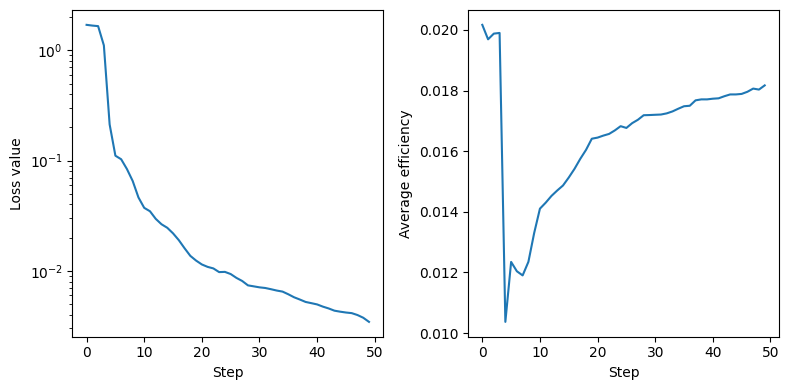

In [12]:
# Plot the loss and efficiency vs. step.
step = onp.arange(len(loss_values))
efficiency = onp.asarray([m["average_efficiency"] for m in metrics_values])

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.semilogy(step, loss_values)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(step, efficiency)
plt.xlabel("Step")
plt.ylabel("Average efficiency")

plt.tight_layout()

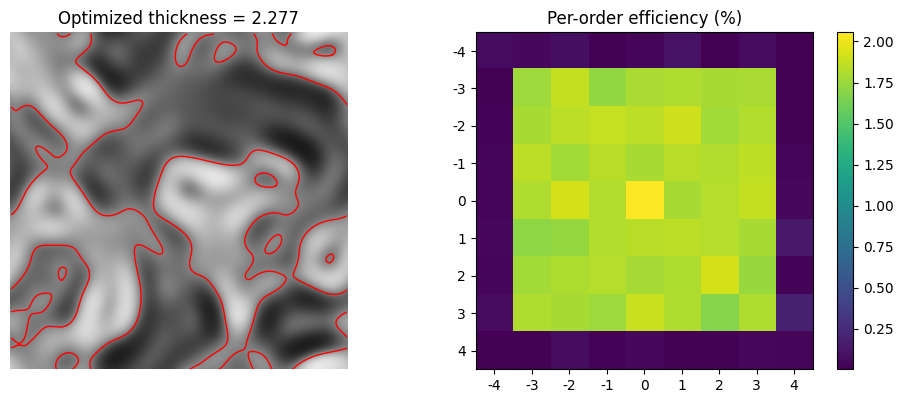

In [21]:
# Plot the optimized density.
plt.figure(figsize=(10, 4))

density = params["density"]
ax = plt.subplot(121)
im = ax.imshow(density.array, cmap="gray")
im.set_clim([0, 1])
ax.axis(False)

contours = measure.find_contours(onp.asarray(density.array))
for c in contours:
    plt.plot(c[:, 1] + 0.5, c[:, 0] + 0.5, "r", lw=1)

plt.title(f"Optimized thickness = {params['thickness'].array:.3f}")

# Plot the per-order diffraction efficiency. We optimize for a 7x7 splitting, but
# plot the efficiencies for 9x9 to show the dropoff in efficiency beyond the target
# splitting orders.
ax = plt.subplot(122)
plt.imshow(100 * challenges.diffract.splitter_challenge.extract_orders_for_splitting(
    response.transmission_efficiency,
    response.expansion,
    (9, 9),
))
ax.set_xticks(onp.arange(9))
ax.set_yticks(onp.arange(9))
ax.set_xticklabels(onp.arange(-4, 5))
ax.set_yticklabels(onp.arange(-4, 5))
plt.colorbar()
plt.title("Per-order efficiency (%)")

plt.tight_layout()

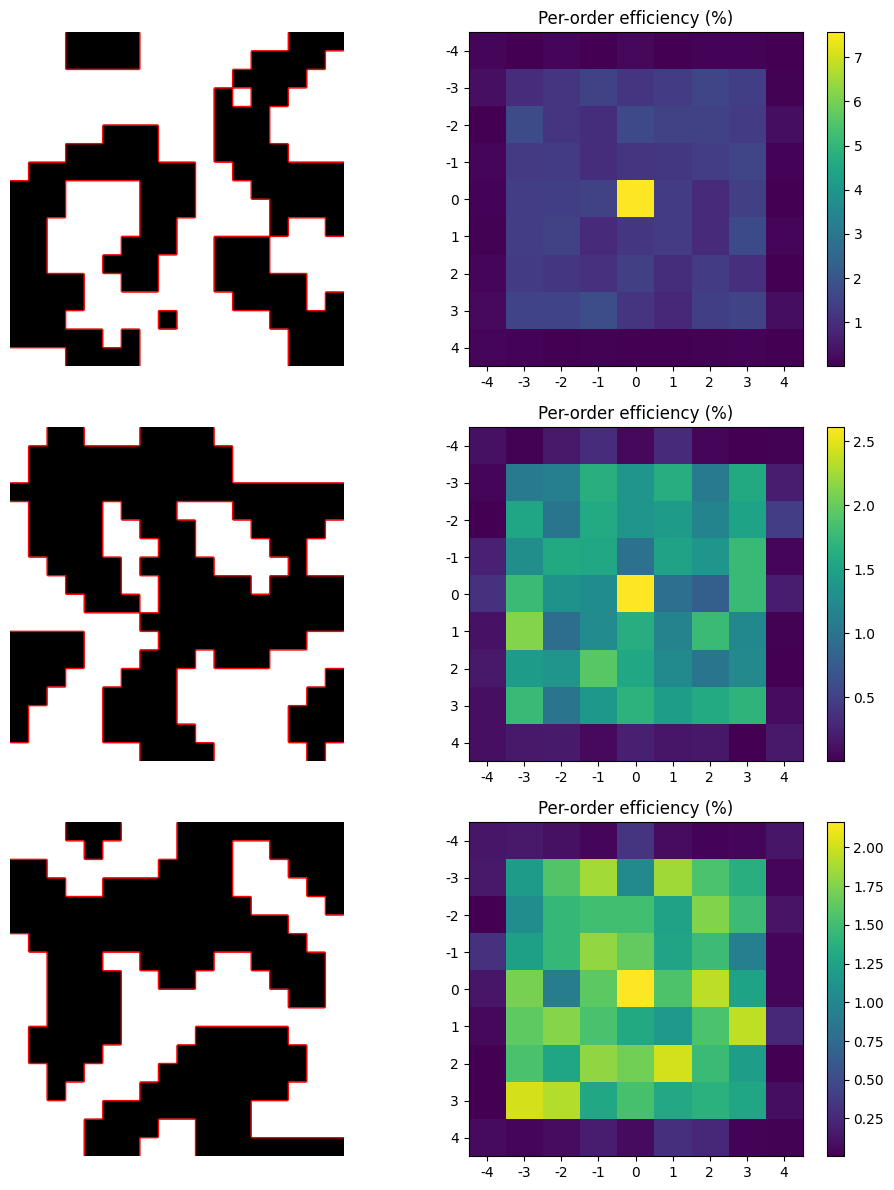

In [31]:
# Load and simulate the reference designs. The efficiencies are comparable to the reference.scr
# https://www.lighttrans.com/fileadmin/shared/UseCases/Application_UC_Rigorous%20Analysis%20of%20Non-paraxial%20Diffractive%20Beam%20Splitter.pdf
fnames = glob.glob("../reference_designs/diffractive_splitter/*.csv")
fnames.sort()

plt.figure(figsize=(10, 4 * len(fnames)))

for i, fname in enumerate(fnames):
    design = onp.genfromtxt(fname, delimiter=",")
    # Increase resolution of the designs.
    design = onp.kron(design, onp.ones((10, 10)))
    reference_params = {
        "thickness": dataclasses.replace(
            params["thickness"],
            array=0.692,
        ),
        "density": dataclasses.replace(
            params["density"],
            array=design,
        ),
    }

    reference_response, _ = challenge.component.response(reference_params)

    ax = plt.subplot(len(fnames), 2, 2 * i + 1)
    ax.imshow(design, cmap="gray")
    ax.axis(False)
    contours = measure.find_contours(design)
    for c in contours:
        plt.plot(c[:, 1], c[:, 0], "r", lw=1)

    # Plot the per-order diffraction efficiency. We optimize for a 7x7 splitting, but
    # plot the efficiencies for 9x9 to show the dropoff in efficiency beyond the target
    # splitting orders.
    ax = plt.subplot(len(fnames), 2, 2 * i + 2)
    plt.imshow(100 * challenges.diffract.splitter_challenge.extract_orders_for_splitting(
        reference_response.transmission_efficiency,
        reference_response.expansion,
        (9, 9),
    ))
    ax.set_xticks(onp.arange(9))
    ax.set_yticks(onp.arange(9))
    ax.set_xticklabels(onp.arange(-4, 5))
    ax.set_yticklabels(onp.arange(-4, 5))
    plt.colorbar()
    plt.title("Per-order efficiency (%)")
    
plt.tight_layout()